In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
import pickle
import gzip

In [3]:
path_to_training_file="/Users/rakadalal/Desktop/Loan Prediction/train.csv"

df = pd.read_csv(path_to_training_file)#Reading the dataset in a dataframe using Pandas

In [4]:
# looking at missing values in all the variables
df.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
# Frequency distribution of Self_Employed variable
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [8]:
# Since ~86% values of Self_Employed are “No”, I am imputing the missing values as “No”
df['Self_Employed'].fillna('No',inplace=True)

In [9]:
# Pivot table to provide median values for all the groups of unique values of Self_Employed and Education features.
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [13]:
# Filling missing values of all variables
# Since ~86% values of Gender are “Male”, I am imputing the missing values as “Male”
df['Gender'].fillna('Male', inplace=True)
# Since ~65% values of Married are “Yes”, I am imputing the missing values as “Yes”
df['Married'].fillna('Yes', inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

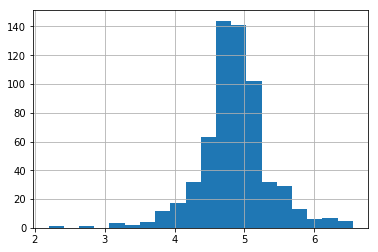

In [15]:
# Treating extreme values of LoanAmount by log transformation
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)
plt.show()

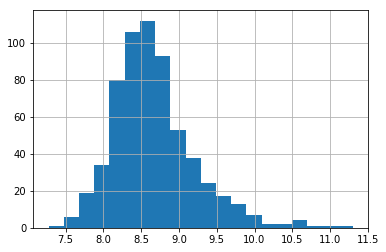

In [16]:
# Combining ApplicantIncome and CoapplicantIncome
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
# Treating extreme values of TotalIncome by log transformation
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=20) 
plt.show()

In [18]:
# Converting all categorical variables into numeric by encoding the categories
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes 

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [19]:
df['Education'].value_counts()

0    480
1    134
Name: Education, dtype: int64

In [50]:
#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])

    #Make predictions on training set:
    predictions = model.predict(data[predictors])

    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    error = []
    for train, test in kf.split(data[predictors]):
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])

        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))

    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

In [51]:
outcome_var = 'Loan_Status'

In [52]:
# Logistic Regression Model
model = LogisticRegression()
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.941%


In [53]:
# Logistic Regression Model with a different combination of variables
model = LogisticRegression()
predictor_var = ['TotalIncome_log', 'LoanAmount_log', 'Credit_History', 'Education', 'Property_Area', 'Dependents']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 80.945%
Cross-Validation Score : 80.928%


In [54]:
# Decision Tree Model
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 88.925%
Cross-Validation Score : 68.077%


In [58]:
# Decision Tree Model with a different combination of variables
model = DecisionTreeClassifier()
predictor_var = ['Loan_Amount_Term', 'LoanAmount_log', 'Credit_History', 'Education', 'Property_Area', 'Dependents']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 96.580%
Cross-Validation Score : 66.124%


In [59]:
# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 79.644%


In [60]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.268845
TotalIncome_log     0.259473
LoanAmount_log      0.228873
Dependents          0.054237
Property_Area       0.049653
Loan_Amount_Term    0.043632
Married             0.025024
Education           0.024471
Self_Employed       0.023778
Gender              0.022015
dtype: float64


In [69]:
# Using 5 variables with most feature importances
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['Credit_History','TotalIncome_log','LoanAmount_log','Dependents','Property_Area']
classification_model(model, df, predictor_var, outcome_var)

Accuracy : 82.899%
Cross-Validation Score : 81.102%


In [73]:
# Saving the best model to disk
path_to_model='./'
f = gzip.open(path_to_model+'model.pklz','wb')
pickle.dump(model,f)
f.close()